## Training of global feature recognizer

**The same neural network architecture as the discriminator is used for the global feature recognizer.**

**The training of the recognizer uses code very similar to GANSim, except in 'train.py', where generator-related code blocks are commented out, indicating that only the discriminator is trained.**

**After commenting out the generator-related code, train_recognizer.py is used to train the recognizer instead of the original train.py in GANSim.**

**Remember set cond_label = True in config.py**

In [1]:
%cd /home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining/

/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining


In [ ]:

% run train_recognizer.py

Num GPUs Available:  1
Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


## Evaluation of the trained global feature recognizer

In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path to directory containing code of this case

In [3]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DChannel/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [4]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = False, cond_prob = False,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
facies_label_thick_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = facies_label_thick_dict['real']
labels_test = facies_label_thick_dict['label']

# Denormalize the global features back into its orginal range 
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis = 1)
mudprop = labels_test[:, 30] 
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677
width = labels_test[:, 31] 
width = (width / 2 + 0.5) * 8 + 27
wvl = labels_test[:, 32]
wvl = (wvl / 2 + 0.5) * 63 + 100
amplt = labels_test[:, 33]
amplt = (amplt / 2 + 0.5) * 104 + 7

print(facies_test.shape)
print(orit_one_hot.shape)
print(orit_class.shape)
print(mudprop.shape)
print(width.shape)
print(wvl.shape)
print(amplt.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


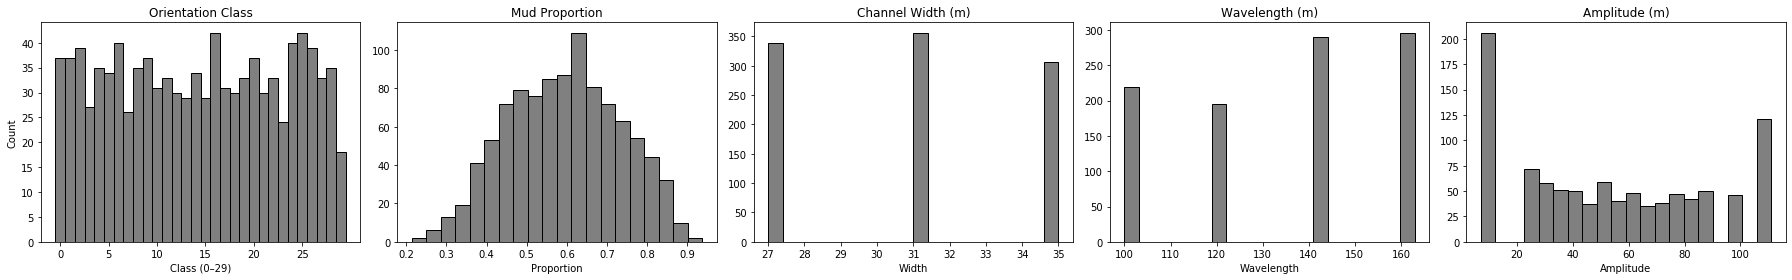

In [6]:
# Create 1-row, 5-column subplot layout
fig, ax = plt.subplots(1, 5, figsize=(25, 4))
plt.subplots_adjust(wspace=0.4)

# Plot orientation class histogram
ax[0].hist(orit_class, bins=np.arange(31)-0.5, color='gray', edgecolor='black')
ax[0].set_title('Orientation Class')
ax[0].set_xlabel('Class (0–29)')
ax[0].set_ylabel('Count')
ax[0].set_xticks(np.arange(0, 30, 5))

# Plot mud proportion histogram
ax[1].hist(mudprop, bins=20, color='gray', edgecolor='black')
ax[1].set_title('Mud Proportion')
ax[1].set_xlabel('Proportion')

# Plot width histogram
ax[2].hist(width, bins=20, color='gray', edgecolor='black')
ax[2].set_title('Channel Width (m)')
ax[2].set_xlabel('Width')

# Plot wavelength histogram
ax[3].hist(wvl, bins=20, color='gray', edgecolor='black')
ax[3].set_title('Wavelength (m)')
ax[3].set_xlabel('Wavelength')

# Plot amplitude histogram
ax[4].hist(amplt, bins=20, color='gray', edgecolor='black')
ax[4].set_title('Amplitude (m)')
ax[4].set_xlabel('Amplitude')

plt.tight_layout()
plt.show()


### 2. Import pre-trained recognizer network

In [7]:
recognizer_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/FeatureRecognizer/'
recognizer_name = 'network-snapshot-069520.pkl' 

In [8]:
# Initialize TensorFlow session.
# If error reported, please try to restart the notebook and skip the training part

tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import networks.
    with open(recognizer_dir + recognizer_name, 'rb') as file:
        _, R, _ = pickle.load(file)

print(R.input_shapes)
print(R.output_shapes)    

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[None, 1, 64, 64], [None, 0, 64, 64]]
[[None, 1], [None], [None], [None, 34]]


### 3. Evaluation of trained recognizer NN

Class 0:  -89 ~ -84
Class 1:  -83 ~ -78
Class 2:  -77 ~ -72
Class 3:  -71 ~ -66
Class 4:  -65 ~ -60
Class 5:  -59 ~ -54
Class 6:  -53 ~ -48
Class 7:  -47 ~ -42
Class 8:  -41 ~ -36
Class 9:  -35 ~ -30
Class 10: -29 ~ -24
Class 11: -23 ~ -18
Class 12: -17 ~ -12
Class 13: -11 ~  -6
Class 14:  -5 ~   0
Class 15:   1 ~   6
Class 16:   7 ~  12
Class 17:  13 ~  18
Class 18:  19 ~  24
Class 19:  25 ~  30
Class 20:  31 ~  36
Class 21:  37 ~  42
Class 22:  43 ~  48
Class 23:  49 ~  54
Class 24:  55 ~  60
Class 25:  61 ~  66
Class 26:  67 ~  72
Class 27:  73 ~  78
Class 28:  79 ~  84
Class 29:  85 ~  89


In [9]:
Rtest_no = facies_test.shape[0]
Rtest_well = np.zeros((Rtest_no, 0, 64, 64)) 
#
labels_Rtest_NN = R.run(facies_test, Rtest_well)[-1]

orit_one_hot_Rtest_NN = labels_Rtest_NN[:, :30]
orit_class_Rtest_NN = np.argmax(orit_one_hot_Rtest_NN, axis = 1) + 1
mudprop_Rtest_NN = labels_Rtest_NN[:, 30]
mudprop_Rtest_NN = (mudprop_Rtest_NN / 2 + 0.5) * 0.8037 + 0.1677
width_Rtest_NN = labels_Rtest_NN[:, 31]
width_Rtest_NN = np.where(width_Rtest_NN <-0.5, -1, np.where(width_Rtest_NN > 0.5, 1, 0))
width_Rtest_NN = (width_Rtest_NN / 2 + 0.5) * 8 + 27
wvl_Rtest_NN = labels_Rtest_NN[:, 32]
wvl_Rtest_NN = np.where(wvl_Rtest_NN <-0.5, -1, np.where(wvl_Rtest_NN < 0, -0.333, np.where(wvl_Rtest_NN > 0.5, 1, 0.333)))
wvl_Rtest_NN = np.round((wvl_Rtest_NN / 2 + 0.5) * 63 + 100)
amplt_Rtest_NN = labels_Rtest_NN[:, 33]
amplt_Rtest_NN = (amplt_Rtest_NN / 2 + 0.5) * 104 + 7

print(orit_class_Rtest_NN.shape)

(1000,)


(30, 30)


Text(0.5, 0, 'Channel direction category label')

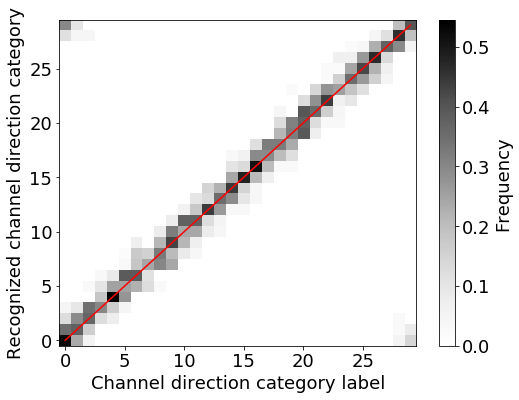

In [10]:
plt.rcParams.update({'font.size': 18})

# 2D Histogram (joint frequency map) with percentage
plt.figure(figsize=(8, 6))

# Generate the 2D histogram data
orit_hist, xedges, yedges, _ = plt.hist2d(orit_class, orit_class_Rtest_NN, 
                                          bins=30, cmap='Blues', density=False)  #29
# Normalize to percentages
orit_hist_percentage = orit_hist/np.sum(orit_hist, axis = 0)  
print(orit_hist_percentage.shape)

# Plot histogram with percentage
plt.clf()  # Clear the current figure to plot again
plt.imshow(orit_hist_percentage.T, origin='lower', cmap='Greys', aspect='auto')

plt.plot(np.arange(0, 30, 1), np.arange(0, 30, 1), 'r-')

# Add colorbar with percentage label
cbar = plt.colorbar()
cbar.set_label('Frequency')

# Set title and axis labels
#plt.title('2D Histogram of Joint Frequency (Percentage)')
plt.ylabel('Recognized channel direction category')
plt.xlabel('Channel direction category label')


#plt.savefig(recognizer_dir + "Histogram_Orientation.jpg", dpi=200)     

(100, 100)


Text(0, 0.5, 'Recognized mud proportion')

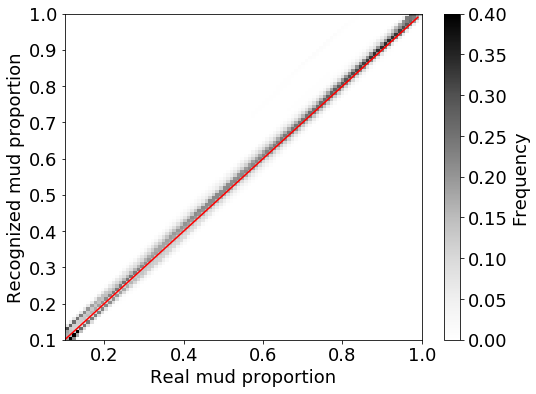

In [11]:
plt.rcParams.update({'font.size': 18})


from scipy.stats import gaussian_kde

# Prepare the data
x = mudprop_Rtest_NN
y = mudprop

# Create a grid for evaluating the KDE
xmin, xmax = 0.1, 1.
ymin, ymax = 0.1, 1.

# Create mesh grid
X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

# Stack the grid points in the right shape for gaussian_kde
grid_coords = np.vstack([X.ravel(), Y.ravel()])

# Apply gaussian_kde to get density estimates
kde = gaussian_kde(np.vstack([x, y]))
mudprop_hist_percentage = kde(grid_coords).reshape(X.shape)  # Reshape the output into a 2D matrix

mudprop_hist_percentage = mudprop_hist_percentage/np.sum(mudprop_hist_percentage, axis = 0)  
print(mudprop_hist_percentage.shape)

# Plot the density map
plt.figure(figsize=(8, 6))
plt.imshow(mudprop_hist_percentage.T, origin='lower', cmap='Greys', extent=[xmin, xmax, ymin, ymax], aspect='auto', vmin=0, vmax=0.4)  # Set vmin and vmax
plt.colorbar(label='Frequency')
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(ymin, ymax, 0.01), 'r-')
#plt.title('Density Map (as Matrix)')
plt.xlabel('Real mud proportion')
plt.ylabel('Recognized mud proportion')

#plt.savefig(recognizer_dir + "Histogram_mudprop.jpg", dpi=200)     


(3, 3)


Text(0.5, 0, 'Channel width label')

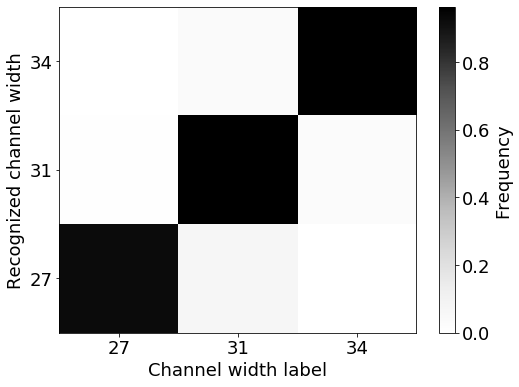

In [12]:
plt.rcParams.update({'font.size': 18})

# 2D Histogram (joint frequency map) with percentage
plt.figure(figsize=(8, 6))

# Generate the 2D histogram data
width_hist, xedges, yedges, _ = plt.hist2d(width, width_Rtest_NN, 
                                          bins=3, cmap='Blues', density=False)  #29
# Normalize to percentages
width_hist_percentage = width_hist/np.sum(width_hist, axis = 0)  
print(width_hist_percentage.shape)

# Plot histogram with percentage
plt.clf()  # Clear the current figure to plot again
plt.imshow(width_hist_percentage.T, origin='lower', cmap='Greys', aspect='auto')

# Add colorbar with percentage label
cbar = plt.colorbar()
cbar.set_label('Frequency')

# Set x and y axis labels to 0, 1, and 2
plt.xticks([0, 1, 2], ['27', '31', '34'])
plt.yticks([0, 1, 2], ['27', '31', '34'])

# Set title and axis labels
#plt.title('2D Histogram of Joint Frequency (Percentage)')
plt.ylabel('Recognized channel width')
plt.xlabel('Channel width label')

#plt.savefig(recognizer_dir + "Histogram_width.jpg", dpi=200)     

(4, 4)


Text(0.5, 0, 'Channel wavelength label')

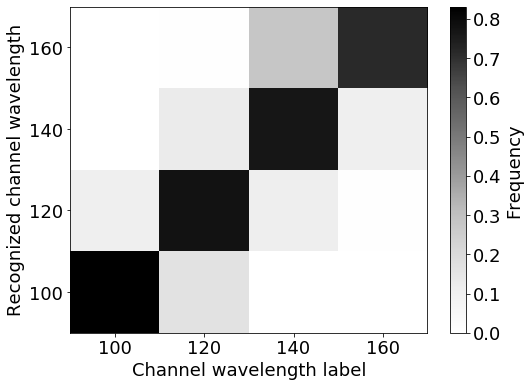

In [13]:
plt.rcParams.update({'font.size': 18})

# 2D Histogram (joint frequency map) with percentage
plt.figure(figsize=(8, 6))

# Generate the 2D histogram data
wvl_hist, xedges, yedges, _ = plt.hist2d(wvl, wvl_Rtest_NN, 
                                          bins=4, cmap='Blues', density=False)  #29
# Normalize to percentages
wvl_hist_percentage = wvl_hist/np.sum(wvl_hist, axis = 0) 
print(wvl_hist_percentage.shape)

# Plot histogram with percentage
plt.clf()  # Clear the current figure to plot again
plt.imshow(wvl_hist_percentage.T, origin='lower', cmap='Greys', aspect='auto')

# Add colorbar with percentage label
cbar = plt.colorbar()
cbar.set_label('Frequency')

plt.xticks([0, 1, 2, 3], ['100', '120', '140', '160'])
plt.yticks([0, 1, 2, 3], ['100', '120', '140', '160'])

# Set title and axis labels
#plt.title('2D Histogram of Joint Frequency (Percentage)')
plt.ylabel('Recognized channel wavelength')
plt.xlabel('Channel wavelength label')
#plt.savefig(recognizer_dir + "Histogram_wavelength.jpg", dpi=200)   


(100, 100)


Text(0, 0.5, 'Recognized channel amplitude')

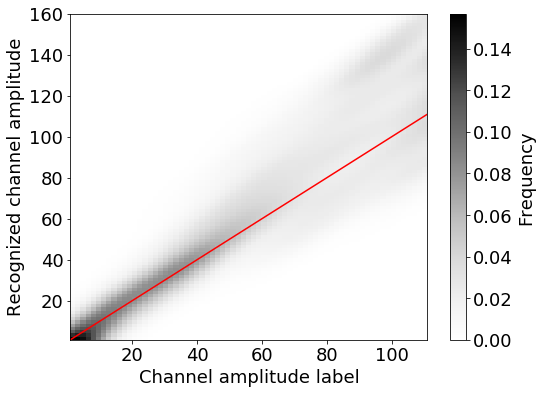

In [14]:
plt.rcParams.update({'font.size': 18})


from scipy.stats import gaussian_kde

# Prepare the data
x = amplt_Rtest_NN
y = amplt

# Create a grid for evaluating the KDE
xmin, xmax = 1, 160.
ymin, ymax = 1, 160.

# Create mesh grid
X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

# Stack the grid points in the right shape for gaussian_kde
grid_coords = np.vstack([X.ravel(), Y.ravel()])

# Apply gaussian_kde to get density estimates
kde = gaussian_kde(np.vstack([x, y]))
amplt_hist_percentage = kde(grid_coords).reshape(X.shape)  # Reshape the output into a 2D matrix

amplt_hist_percentage = amplt_hist_percentage/np.sum(amplt_hist_percentage, axis = 0)  
print(amplt_hist_percentage.shape)


# Plot the density map
plt.figure(figsize=(8, 6))
plt.imshow(amplt_hist_percentage.T, origin='lower', cmap='Greys', extent=[xmin, xmax, ymin, ymax], aspect='auto')  # Set vmin and vmax
plt.colorbar(label='Frequency')
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(ymin, ymax, 0.01), 'r-')


#plt.scatter(amplt, amplt - amplt * 0.2, color='b')
#plt.scatter(amplt, amplt + 0.15 * wvl + amplt * 0.2, color='b')

# Set the x and y-axis limits
plt.xlim(1, 111)  # Range for x-axis
plt.ylim(1, 160)  # Adjust this if needed for the y-axis

#plt.title('Density Map (as Matrix)')
plt.xlabel('Channel amplitude label')
plt.ylabel('Recognized channel amplitude')

#plt.savefig(recognizer_dir + "Histogram_amplitude.jpg", dpi=200)     


Text(0, 0.5, 'Recognized amplitude value')

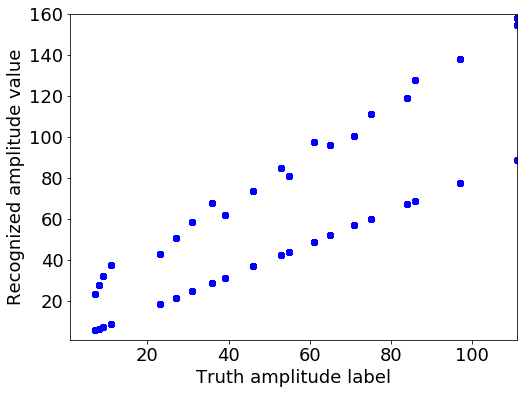

In [15]:
# The error of amplitude labels due to noises

plt.rcParams.update({'font.size': 18})

from scipy.stats import gaussian_kde

# Plot the density map
plt.figure(figsize=(8, 6))
# Prepare the data
x = amplt_Rtest_NN
y = amplt

plt.scatter(amplt, amplt - amplt * 0.2, color='b')
plt.scatter(amplt, amplt + 0.15 * wvl + amplt * 0.2, color='b')

# Set the x and y-axis limits
plt.xlim(1, 111)  # Range for x-axis
plt.ylim(1, 160)  # Adjust this if needed for the y-axis

#plt.title('Density Map (as Matrix)')
plt.xlabel('Truth amplitude label')
plt.ylabel('Recognized amplitude value')

# plt.savefig(recognizer_dir + "Histogram_amplitude_range.jpg", dpi=200)     
